<a href="https://colab.research.google.com/github/tismadusan567/parallelized-game-of-life/blob/main/projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#utils
import random
import threading
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from copy import deepcopy
import pprint
import time
import multiprocessing as mp

N = 15
STEP = 50
CS = N #chunk size

def bounds(row, col):
  return row >= 0 and col >= 0 and row < N and col < N

def getNeighbours(row, col):
  neighbours = []
  for i in range(-1, 2):
    for j in range(-1, 2):
      if (i != 0 or j != 0) and bounds(row + i, col + j):
        neighbours.append((row + i, col + j))
  return neighbours

def nextState(state, alive):
  if alive < 2:
    return False
  if alive > 3:
    return False
  if state == True and (alive == 2 or alive == 3):
    return True
  if state == False and alive == 3:
    return True
  return False

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim

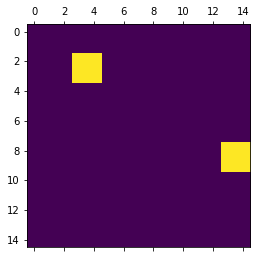

In [ ]:
#1a
states = [[random.choice([True, False]) for _ in range(N)] for _ in range(N)]
inq = 0; inqLock = threading.Lock()
outq = N**2; outqLock = threading.Lock()
inqFull = True; inqFullLock = threading.Lock()
wait = N/400

counters = [[0 for _ in range(N)] for _ in range(N)]
counterLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
stateLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
statesHistory = []

def g1a(tid, steps = STEP):
  global inq
  global outq
  global inqFull
  global states
  for i in range(steps):
    inqLock.acquire()
    if inq == 0:
      
      while True:
        brk = False
        outqLock.acquire()
        if outq == N**2:
          brk = True
        outqLock.release()
        if brk:
          break
        time.sleep(wait)
      
      # save state
      statesHistory.append(deepcopy(states))
      global counters 
      counters = [[0 for _ in range(N)] for _ in range(N)]

      inqFullLock.acquire()
      inqFull = False
      inqFullLock.release()

    inq += 1
    if inq == N**2:
      inqFullLock.acquire()
      inqFull = True
      inqFullLock.release()
      inq = 0
      outqLock.acquire()
      outq = 0
      outqLock.release()

    inqLock.release()
    row, col = tid // N, tid % N
    stateLocks[row][col].acquire()
    state = states[row][col]
    stateLocks[row][col].release()

    alive = 0
    neighbours = getNeighbours(row, col)
    for nrow, ncol in neighbours:
      stateLocks[nrow][ncol].acquire()
      if states[nrow][ncol] == True:
        alive += 1
      counterLocks[nrow][ncol].acquire()
      counters[nrow][ncol] += 1
      counterLocks[nrow][ncol].release()
      stateLocks[nrow][ncol].release()
    
    next = nextState(state, alive)

    
    neighbourCount = len(neighbours)
    while True:
      brk = False
      counterLocks[row][col].acquire()
      if counters[row][col] == neighbourCount:
        brk = True
      counterLocks[row][col].release()
      if brk:
        break
      time.sleep(wait)
    stateLocks[row][col].acquire()
    states[row][col] = next
    stateLocks[row][col].release()

    while True:
      brk = False 
      inqFullLock.acquire()
      if inqFull:
        brk = True
      inqFullLock.release()
      if brk:
        break
      time.sleep(wait)
    
    outqLock.acquire()
    outq += 1
    outqLock.release()

#threads 1a
threads = [threading.Thread(target = g1a, args = (i,)) for i in range(N**2)]
for thread in threads:
  thread.start()
for thread in threads:
  thread.join()

anim = animate(statesHistory);
HTML(anim.to_html5_video())

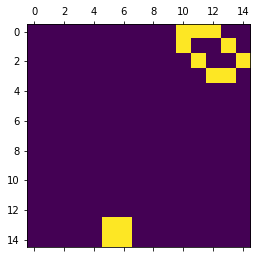

In [ ]:
#1b
states = [[random.choice([True, False]) for _ in range(N)] for _ in range(N)]
inq = 0; inqLock = threading.Lock()
cond = threading.Condition()

counters = [[0 for _ in range(N)] for _ in range(N)]
counterLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
stateLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
statesHistory = []

def g1b(tid, steps = STEP):
  global inq
  global states
  for i in range(steps):
    
    inqLock.acquire()
    inq += 1
    if inq == N**2:
      # save state
      statesHistory.append(deepcopy(states))
      global counters 
      counters = [[0 for _ in range(N)] for _ in range(N)]
      inq = 0
      inqLock.release()
      with cond:
        cond.notifyAll()
    else:
      inqLock.release()
      with cond:
        cond.wait()
    
    row, col = tid // N, tid % N
    stateLocks[row][col].acquire()
    state = states[row][col]
    stateLocks[row][col].release()

    alive = 0
    neighbours = getNeighbours(row, col)
    for nrow, ncol in neighbours:
      stateLocks[nrow][ncol].acquire()
      if states[nrow][ncol] == True:
        alive += 1
      counterLocks[nrow][ncol].acquire()
      counters[nrow][ncol] += 1
      counterLocks[nrow][ncol].release()
      stateLocks[nrow][ncol].release()
    
    next = nextState(state, alive)
    
    neighbourCount = len(neighbours)
    while True:
      brk = False
      counterLocks[row][col].acquire()
      if counters[row][col] == neighbourCount:
        brk = True
      counterLocks[row][col].release()
      if brk:
        break
      time.sleep(wait)
    stateLocks[row][col].acquire()
    states[row][col] = next
    stateLocks[row][col].release()
    
#threads 1a
threads = [threading.Thread(target = g1b, args = (i,)) for i in range(N**2)]
for thread in threads:
  thread.start()
for thread in threads:
  thread.join()

anim = animate(statesHistory);
HTML(anim.to_html5_video())

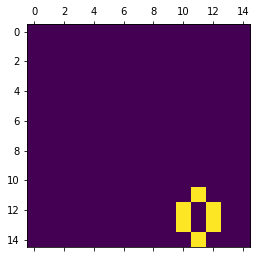

In [ ]:
#1c
states = [[random.choice([True, False]) for _ in range(N)] for _ in range(N)]
counters = [[0 for _ in range(N)] for _ in range(N)]
counterLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
stateLocks = [[threading.Lock() for _ in range(N)] for _ in range(N)]
statesHistory = []

def exportState():
    statesHistory.append(deepcopy(states))
    global counters 
    counters = [[0 for _ in range(N)] for _ in range(N)]
barrier = threading.Barrier(N**2, exportState)

def g1c(tid, steps = STEP):
  global states
  for i in range(steps):

    barrier.wait()

    row, col = tid // N, tid % N
    stateLocks[row][col].acquire()
    state = states[row][col]
    stateLocks[row][col].release()

    alive = 0
    neighbours = getNeighbours(row, col)
    for nrow, ncol in neighbours:
      stateLocks[nrow][ncol].acquire()
      if states[nrow][ncol] == True:
        alive += 1
      counterLocks[nrow][ncol].acquire()
      counters[nrow][ncol] += 1
      counterLocks[nrow][ncol].release()
      stateLocks[nrow][ncol].release()
    
    next = nextState(state, alive)
    
    neighbourCount = len(neighbours)
    while True:
      brk = False
      counterLocks[row][col].acquire()
      if counters[row][col] == neighbourCount:
        brk = True
      counterLocks[row][col].release()
      if brk:
        break
      time.sleep(wait)
    stateLocks[row][col].acquire()
    states[row][col] = next
    stateLocks[row][col].release()

#threads 1c
threads = [threading.Thread(target = g1c, args = (i,)) for i in range(N**2)]
for thread in threads:
  thread.start()
for thread in threads:
  thread.join()

anim = animate(statesHistory);
HTML(anim.to_html5_video())

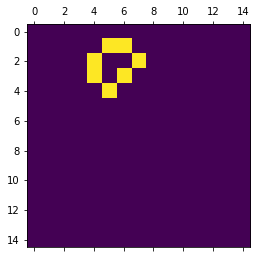

In [ ]:
#2
states = [[random.choice([True, False]) for _ in range(N)] for _ in range(N)]
statesHistory = []
def mastermind(pid, inques, expque, steps = STEP):
  states = [[[False for _ in range(N)] for _ in range(N)] for _ in range(steps)]
  for i in range(steps * N**2):
    iter, state, row, col = inques.get()
    states[iter][row][col] = state
  expque.put(states)

def g2(pid, inques, outques, expque, state, steps = STEP):
  for i in range(steps):
    expque.put((i, state, pid // N, pid % N))
    for j in outques:
      j.put(state)

    alive = 0
    for j in inques:
      nstate = j.get()
      if nstate == True:
        alive += 1
      
    state = nextState(state, alive)

#processes 2
queues = [[([],[]) for _ in range(N)] for _ in range(N)]
for row in range(N): 
  for col in range(N):
    neighbours = getNeighbours(row, col)
    for nrow, ncol in neighbours:
      q = mp.Queue()
      queues[row][col][0].append(q)
      queues[nrow][ncol][1].append(q)
mmQue = mp.Queue()
expQue = mp.Queue()

mmProc = mp.Process(target = mastermind, args = (N**2, mmQue, expQue))
processes = [mp.Process(target = g2, args = (i, queues[i // N][i % N][0], queues[i // N][i % N][1], mmQue, states[i // N][i % N])) for i in range(N**2)]

mmProc.start()
for proc in processes:
  proc.start()

mmProc.join()
for proc in processes:
  proc.join()

statesHistory = expQue.get()

anim = animate(statesHistory);
HTML(anim.to_html5_video())

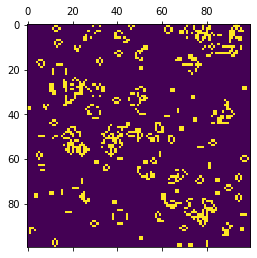

In [ ]:
#3
states = [[random.choice([True, False]) for _ in range(N)] for _ in range(N)]
sharedStates = mp.Array('b', [item for row in states for item in row], lock = False)
statesHistory = [[] for i in range(STEP)]
def g3(coords):
  row, col = coords // N, coords % N
  neighbours = getNeighbours(row, col)
  state = sharedStates[coords]
  alive = 0
  for j in neighbours:
    nidx = j[0] * N + j[1]
    if sharedStates[nidx] != 0:
      alive += 1

  return row, col, nextState(state, alive)

#processes 3
pool = mp.Pool(8)
for i in range(STEP):
  statesHistory[i] = [[sharedStates[k * N + j] for j in range(N)] for k in range(N)]
  nstates = pool.map(g3, [j for j in range(N**2)], chunksize = CS)
  for j in nstates:
    sharedStates[j[0] * N + j[1]] = j[2]

pool.close()

anim = animate(statesHistory);
HTML(anim.to_html5_video())